#### Import Data Sets from the following sources and transform to one record per zip code:

* 2016 Census population estimates by zip code from factfinder.census.gov
* OSHPD hospital and emergency room utilization data by zip code from oshpd.ca.gov
* ESRI Tapestry consumer segmentation data by zip code from ESRI / ArcGIS
* CA Area Deprivation Index by zip code from https://www.neighborhoodatlas.medicine.wisc.edu/
* Schedule drug metrics by zip code from ...

#### Merge data sets into one dataframe and calculate ratios:

* Hosp and ED util per 1,000 population
* 

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as plb
import matplotlib.ticker as mtick
import scipy.stats as stats

In [2]:
# Read 2016 census population estimates
ca_census_pop_2016_df = pd.read_csv("ACS_16_5YR_B01003_with_ann.csv",skiprows=1)
ca_census_df = ca_census_pop_2016_df[['Id2','Estimate; Total']]
ca_census_df = ca_census_df.rename(columns={'Id2':'Zip','Estimate; Total':'2016_Census_Pop_Est'})

# drop non-CA zips
ca_census_df = ca_census_df.drop([0,1,2,3,4,5]) # NV zips

#ca_census_df.count()
ca_census_df.head()

,Zip,2016_Census_Pop_Est
6,90001,57942
7,90002,51826
8,90003,70208
9,90004,63095
10,90005,39338


In [3]:
# Read 2016 census population estimates with some age/sex detail
ca_census_demo_df = pd.read_csv("ACS_16_5YR_DP05_with_ann.csv",skiprows=1)
ca_census_demo_df = ca_census_demo_df.rename(columns={'Id2':'Zip','Estimate; Total':'2016_Census_Pop_Est'})

# drop non-CA zips
ca_census_demo_df = ca_census_demo_df.drop([0,1,2,3,4,5]) # NV zips
#ca_census_demo_df.head()

In [4]:
# Read 2016 CA OSHPD Utilization file
ca_hosp_2016_df = pd.read_csv("POMS2016.csv")

# Limit to data that can be aggregated by pt zip code
ca_hosp_2016_df = ca_hosp_2016_df[['pzip','pcounty','year','pattype','discharges']]

# Use groupby to summarize discharges by pzip, pcounty, year and pattype
ca_hosp_2016_df = ca_hosp_2016_df.groupby(['pzip','pcounty','year','pattype']).sum()
ca_hosp_2016_df = ca_hosp_2016_df.reset_index()
ca_hosp_2016_df = ca_hosp_2016_df.set_index(['pzip','pcounty','year'])
ca_hosp_2016_df = ca_hosp_2016_df.pivot_table(index=['pzip','pcounty','year'], columns='pattype',values='discharges').reset_index()

# drop records with no zip code (ie. ARIZONA, HOMELESS, etc in pzip column)
ca_hosp_2016_df = ca_hosp_2016_df.drop([2672,2673,2674,2675,2676,2677,2678])

# convert pzip from string to int
ca_hosp_2016_df['pzip'] = ca_hosp_2016_df['pzip'].apply(pd.to_numeric)

#ca_hosp_2016_df.count()
ca_hosp_2016_df.head()

pattype,pzip,pcounty,year,AS Only,ED Only,Inpatient,Inpatient from ED
0,90001,LOS ANGELES,2016,1798.0,24554.0,3628.0,3286.0
1,90002,LOS ANGELES,2016,1661.0,25168.0,3421.0,3314.0
2,90003,LOS ANGELES,2016,2111.0,32061.0,4610.0,4648.0
3,90004,LOS ANGELES,2016,2115.0,15820.0,2751.0,2639.0
4,90005,LOS ANGELES,2016,1107.0,8650.0,1579.0,1488.0


In [64]:
drug_sched_df = pd.read_csv("schedule_drugs_table9_presciptions_by_year_locale_drugschedule.csv")

# create dataframe with only 2016 drug data
drug_sched_2016_df = drug_sched_df.loc[drug_sched_df['xYear']==2016]

drug_sched_2016_df = drug_sched_2016_df[['Zip','County','State','xYear','Schedule_Group','RxCount']]
drug_sched_2016_df = drug_sched_2016_df.set_index(['Zip','County','State','xYear'])
drug_sched_2016_df = drug_sched_2016_df.pivot_table(index=['Zip','County','State','xYear'], columns='Schedule_Group', values='RxCount').reset_index()
drug_sched_2016_df = drug_sched_2016_df.rename(columns={'2':'C2','3':'C3','4':'C4','All':'C2-C4'})
#drug_sched_2016_df['C2 per 1,000'] = drug_sched_2016_df['C2']/drug_sched_2016_df['Population']
drug_sched_2016_df.head()


Schedule_Group,Zip,County,State,xYear,C2,C3,C4,C2-C4
0,90001,Los Angeles,CA,2016,843,201,1710,2754
1,90002,Los Angeles,CA,2016,357,767,1059,2183
2,90003,Los Angeles,CA,2016,1329,259,2440,4028
3,90004,Los Angeles,CA,2016,3582,1707,5002,10291
4,90005,Los Angeles,CA,2016,439,1403,1434,3276


In [74]:
drug_metrics_df = pd.read_csv("schedule_drugs_table2_metrics_by_year_and_zip.csv")

# create dataframe with only 2016 drug data
drug_metrics_2016_df = drug_metrics_df.loc[drug_metrics_df['xYear']==2016]

#drug_metrics_df.sort_values('Zip')
# what % of records are unique Zips
drug_metrics_2016_df['Zip'].nunique()/drug_metrics_2016_df['Zip'].count()

rx_count_2016_df = drug_metrics_2016_df[['Zip','Rx_count_Dis']]

# Merge controlled Rx with total Rx count
rx_data_df = rx_count_2016_df.merge(drug_sched_2016_df,on='Zip', how='outer')
rx_data_df = rx_data_df[['Zip','County','State','Rx_count_Dis','C2','C3','C4','C2-C4']]

# Calculate C2 penetration & C2-C4 penetration rates
rx_data_df['Pct_C2'] = rx_data_df['C2']/rx_data_df['Rx_count_Dis']
rx_data_df['Pct_C2-C4'] = rx_data_df['C2-C4']/rx_data_df['Rx_count_Dis']

rx_data_df.head()

,Zip,County,State,Rx_count_Dis,C2,C3,C4,C2-C4,Pct_C2,Pct_C2-C4
0,90001,Los Angeles,CA,7653,843,201,1710,2754,0.110153,0.359859
1,90002,Los Angeles,CA,6483,357,767,1059,2183,0.055067,0.336727
2,90003,Los Angeles,CA,484,1329,259,2440,4028,2.745868,8.322314
3,90004,Los Angeles,CA,3318,3582,1707,5002,10291,1.079566,3.101567
4,90005,Los Angeles,CA,1579,439,1403,1434,3276,0.278024,2.074731


In [5]:
# Read Tapestry segments by CA zip
tapestry_df = pd.read_csv("Tapestry_by_CA_Zip.csv")
tapestry_df.head()

,ZIP Code,NAME,Dominant Tapestry Segment Number per Zip,Dominant Tapestry Segment Code per Zip,Dominant Tapestry Segment Name per Zip,Dominant Lifemode Code,Dominant Lifemode Group Name
0,90001.0,Los Angeles,61.0,13B,Las Casas,13.0,Next Wave
1,90002.0,Los Angeles,61.0,13B,Las Casas,13.0,Next Wave
2,90003.0,Los Angeles,61.0,13B,Las Casas,13.0,Next Wave
3,90004.0,Los Angeles,60.0,13A,International Marketplace,13.0,Next Wave
4,90005.0,Los Angeles,62.0,13C,NeWest Residents,13.0,Next Wave


In [6]:
ca_adi_df = pd.read_csv("CA_ADI_by_ZIP.csv")
ca_adi_df.head()

,Zip,ADI_STATERNK,ADI_NATRANK
0,90001,8.007138,45.794018
1,90002,8.125497,50.517541
2,90003,7.972540,46.906751
3,90004,4.238019,28.200175
4,90005,7.225923,57.775878


####  Merge all relevant data sets into one dataframe

In [12]:
combo1_df = ca_census_df.merge(ca_hosp_2016_df, left_on='Zip', right_on='pzip', how='outer')

# Add Ambulatory Surgery (AS), Emergency Dept (ED), Inpatient (discharges) and Inpatient from ED utilization rates per 1,000 pop
combo1_df['AS per 1,000'] = combo1_df['AS Only'] / combo1_df['2016_Census_Pop_Est']
combo1_df['ED per 1,000'] = combo1_df['ED Only'] / combo1_df['2016_Census_Pop_Est']
combo1_df['IP per 1,000'] = combo1_df['Inpatient'] / combo1_df['2016_Census_Pop_Est']
combo1_df['IP via ED per 1,000'] = combo1_df['Inpatient from ED'] / combo1_df['2016_Census_Pop_Est']

combo1_df.head()

# what % of records are unique Zips
combo1_df['Zip'].nunique()/combo1_df['Zip'].count()

1.0

In [89]:
# Merge all relevant data sets
combo2_df = combo1_df.merge(rx_data_df, on='Zip', how='outer')

# Calculate drug utilization ratios per 1,000 population
combo2_df['C2 per 1,000'] = combo2_df['C2']/combo2_df['2016_Census_Pop_Est']
combo2_df['C3 per 1,000'] = combo2_df['C3']/combo2_df['2016_Census_Pop_Est']
combo2_df['C4 per 1,000'] = combo2_df['C4']/combo2_df['2016_Census_Pop_Est']
combo2_df['C2-C4 per 1,000'] = combo2_df['C2-C4']/combo2_df['2016_Census_Pop_Est']
combo2_df['Tot Rx per 1,000'] = combo2_df['Rx_count_Dis']/combo2_df['2016_Census_Pop_Est']


combo3_df = combo2_df.merge(ca_adi_df, on='Zip', how='outer')
combo3_df.count()

Zip                    2611
2016_Census_Pop_Est    1769
pzip                   2672
pcounty                2672
year                   2672
AS Only                2457
ED Only                2634
Inpatient              2504
Inpatient from ED      2500
AS per 1,000           1753
ED per 1,000           1763
IP per 1,000           1753
IP via ED per 1,000    1753
County                 2603
State                  2603
Rx_count_Dis           2603
C2                     2603
C3                     2603
C4                     2603
C2-C4                  2603
Pct_C2                 1661
Pct_C2-C4              1727
C2 per 1,000           1745
C3 per 1,000           1744
C4 per 1,000           1744
C2-C4 per 1,000        1745
Tot Rx per 1,000       1740
ADI_STATERNK           1582
ADI_NATRANK            1582
dtype: int64

In [100]:
# Remove duplicate columns
combo4_df = combo3_df[['Zip','County','State','year','2016_Census_Pop_Est','AS Only','ED Only', \
                       'Inpatient','Inpatient from ED','AS per 1,000','ED per 1,000','IP per 1,000', \
                       'IP via ED per 1,000','Rx_count_Dis','C2','C3','C4','C2-C4','Pct_C2','Pct_C2-C4', \
                       'C2 per 1,000','C3 per 1,000','C4 per 1,000','C2-C4 per 1,000','Tot Rx per 1,000', \
                       'ADI_STATERNK','ADI_NATRANK']]

# Clean null and infinite values from data
combo5_df = combo4_df.replace([np.inf, -np.inf], np.nan)
combo6_df = combo5_df.dropna(axis=0)
combo6_df.count()

combo6_df.to_csv(f"Combined_Hosp_Drug_Util.csv", encoding='utf-8')

###  Calculate Regression Statistics

In [91]:
ind_var1 = list(combo6_df['ADI_STATERNK'])
dep_var1 = list(combo6_df['ED per 1,000'])

stats.pearsonr(ind_var1, dep_var1)

(0.5211458278184551, 3.8904119210874145e-77)

In [92]:
ind_var2 = list(combo6_df['ADI_NATRANK'])
dep_var1 = list(combo6_df['ED per 1,000'])

stats.pearsonr(ind_var2, dep_var1)

(0.5144571099349013, 6.88365281200494e-75)

In [93]:
ind_var2 = list(combo6_df['ADI_NATRANK'])
dep_var2 = list(combo6_df['C2 per 1,000'])

stats.pearsonr(ind_var2, dep_var2)

(-0.04001223427108595, 0.18622070122079395)

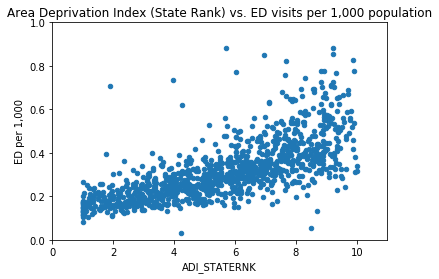

In [94]:
combo6_df.plot(x='ADI_STATERNK', y='ED per 1,000', kind='scatter', xlim=(0,11), ylim=(0,1), title='Area Deprivation Index (State Rank) vs. ED visits per 1,000 population')


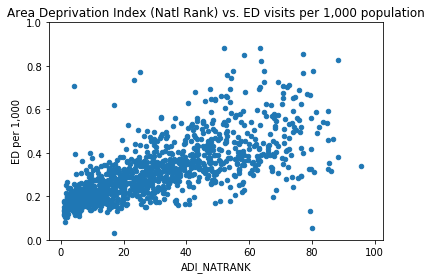

In [95]:
combo6_df.plot(x='ADI_NATRANK', y='ED per 1,000', kind='scatter', ylim=(0,1), title='Area Deprivation Index (Natl Rank) vs. ED visits per 1,000 population')

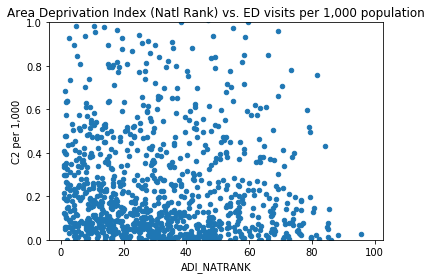

In [96]:
combo6_df.plot(x='ADI_NATRANK', y='C2 per 1,000', kind='scatter', ylim=(0,1), title='Area Deprivation Index (Natl Rank) vs. ED visits per 1,000 population')